# DCGAN Test on MOMA Data<a name="top"></a>

This script uses a slightly modified Keras DCGAN to generate artifical mass spectra with deep learning. The MOMA ML dataset was converted to grayscale images by first scaling the relative abundance of each scan to be between [0,1] with 1 being the base peak. Next the scan was reshaped from 1D to a 36x36 2D array before being fed into the network.

<h3 align="center"><b>Hematite Training Process</b></h3>

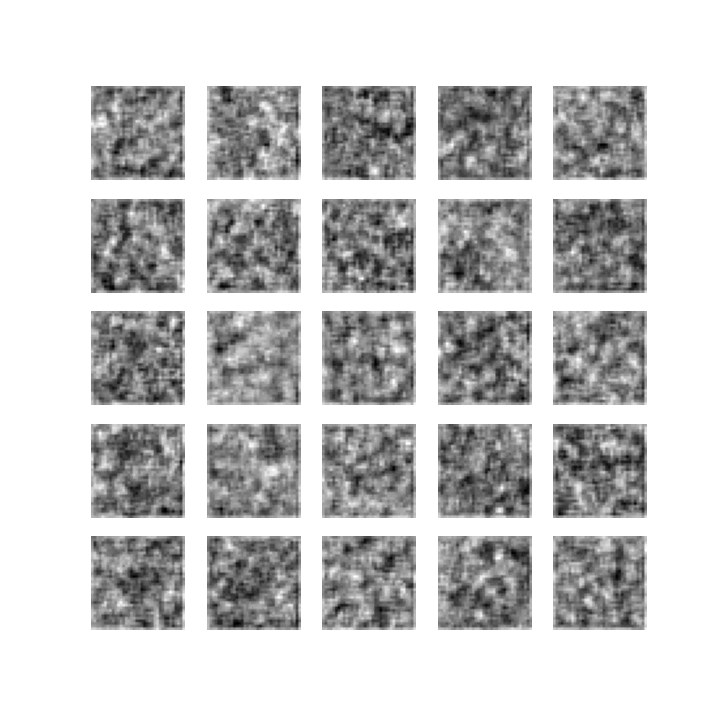

## Setup

In [79]:
%matplotlib inline
import os
from os import makedirs
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
from numpy.random import randn, randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [131]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Dense, LSTM, Activation, Input, Bidirectional, Dropout, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.layers import Reshape, Conv2DTranspose, TimeDistributed, Conv1D, LeakyReLU, Layer, ReLU, ZeroPadding2D, Conv2D, UpSampling2D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.models import load_model, model_from_json

In [5]:
# GPU Check
tf.test.is_gpu_available()

True

# Prepare the Data

In [6]:
# Load dataset into pandas dataframe
full_df = pd.read_csv('full_ml_data.csv')
full_df.name = "Full Dataset"

In [8]:
# Normalize the spectral columns to be between 0 and 1, scaled by the max value in that row
# norm_spec_df = full_df.iloc[:,1:2001].apply(lambda x: x/x.max(), axis=1)
norm_spec_df = full_df.iloc[:,1:1297].apply(lambda x: x/x.max(), axis=1)

In [9]:
# Pad with zero columns if needed 
# for i in range(1,191):
#     col_name = str(1105 + i)
#     col_index = 1105 + i
#     norm_spec_df.insert(col_index,col_name,0,True)

In [198]:
sample_counts = full_df['sample_label'].value_counts()
sample_counts[:10]

CsI                                2814
Hematite                           2372
Au-Coated CsI                      1980
TiO2                               1884
Thin section (R-Gypsum)            1848
Yellowstone Green stream powder    1023
Atacama                             988
Thin section (Fspat1 (Ab83))        813
G24 powder                          774
Gypsum                              753
Name: sample_label, dtype: int64

In [388]:
target_name = 'CsI'

In [373]:
# Get all rows for the target sample label
target_rows = full_df.loc[full_df['sample_label'] == target_name].index

# Create dataframe of only target sample
target_df = norm_spec_df.iloc[target_rows]

target_df.shape

(2814, 1296)

In [374]:
# Check the range of masses
# for column in norm_spec_df.columns:
#     print('Column: ',column," sum:",norm_spec_df[column].sum())

In [375]:
# Reshape mass specs into a square
target_train = np.reshape(target_df.values,(target_df.shape[0],36,36,1))

In [376]:
print(f"Number of examples: {len(target_train)}")
print(f"Shape of the images in the dataset: {target_train.shape[1:]}")

Number of examples: 2814
Shape of the images in the dataset: (36, 36, 1)


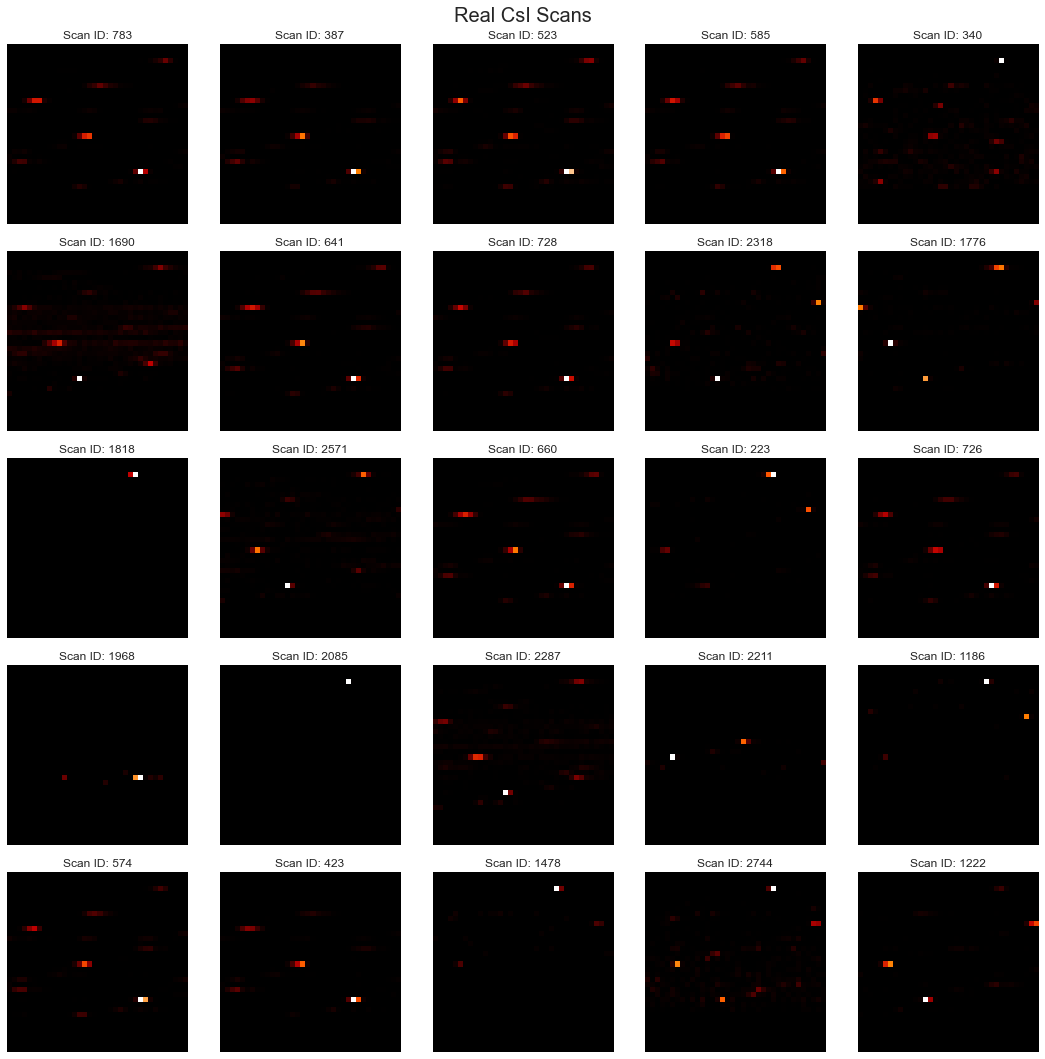

In [377]:
# Display mass spec as 36x36 image
plt.figure(1, figsize=(15, 15))
plt.suptitle('Real ' + target_name + ' Scans', fontsize=20)

k = 0
for i in random.sample(range(0,len(target_df)), 25):
    plt.subplot(5, 5, k+1)
    plt.imshow(np.array(target_df.iloc[i]).reshape(36,36),cmap='gist_heat')
    plt.axis('off')
    plt.title('Scan ID: '+str(i))
    k += 1
    
plt.tight_layout()
plt.show()

## Model

In [17]:
img_dim = 36
LATENT_DIM = 100
NUM_CHANNELS = 1

In [ ]:
# https://github.com/jacobgil/keras-dcgan
class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = img_dim
        self.img_cols = img_dim
        self.channels = NUM_CHANNELS
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = LATENT_DIM
        self.model_save_dir = 'DCGAN/models/' + target_name + '/'
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def save_models(self, epoch):
        self.save_model(self.discriminator,
                        os.path.join(self.model_save_dir, 'discriminator_model' + '_' + str(epoch)))
        self.save_model(self.generator,
                        os.path.join(self.model_save_dir, 'generator_model' + '_' + str(epoch)))
        self.save_model(self.combined,
                        os.path.join(self.model_save_dir, 'combined_model' + '_' + str(epoch)))

    def save_model(self, model, model_path):
        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        model.save_weights(str(model_path + '.h5'))
        
    # create a line plot of loss for the gan and save to file
    def plot_history(self, d1_hist, d2_hist, g_hist):
        # Convert to arrays, probably a better way
        d1_hist = np.array(d1_hist)
        d2_hist = np.array(d2_hist)
        g_hist = np.array(g_hist)
        # plot history
        plt.figure(figsize=(20,10))
        plt.plot(d1_hist[:,0], label='crit_real')
        plt.plot(d2_hist[:,0], label='crit_fake')
        plt.plot(g_hist, label='gen')
        plt.legend()
        plt.savefig("DCGAN/images/" + target_name + '/' + 'plot_line_plot_loss_%s.png' % target_name)
        plt.close()

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 9 * 9, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((9, 9, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):
        
        # Create directory to save model results
        if not os.path.isdir(self.model_save_dir):
            os.makedirs(self.model_save_dir)

        # Load the dataset
        X_train = target_df.to_numpy().reshape(len(target_df), img_dim, img_dim,1)

        # Rescale -1 to 1
        X_train = 2 * X_train - 1.

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # lists for keeping track of loss
        c1_hist, c2_hist, g_hist = list(), list(), list()
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            c1_hist.append(d_loss_real)
            c2_hist.append(d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)
            g_hist.append(g_loss)
            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.save_models(epoch)
        
        # line plots of loss
        self.plot_history(c1_hist, c2_hist, g_hist)

    def save_imgs(self, epoch):
        # Create save directory if needed
        img_dir = "DCGAN/images/" + target_name + '/'
        if not os.path.isdir(img_dir):
            os.makedirs(img_dir)
        
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c, figsize=(10,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(img_dir + "mass_spec_" + target_name.strip() + "%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)

## Compare Results

In [389]:
# load json and create model
json_file = open('DCGAN/models/CsI/generator_model_3800.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("DCGAN\models\CsI\generator_model_3800.h5")

In [540]:
# generate some samples
noise = np.random.normal(0, 1, (1, LATENT_DIM))
gen_imgs = loaded_model.predict(noise)

# rescale from [0,1]
gen_imgs = .5 * gen_imgs + .5

# Reshape back to spectrum
gen_spec = gen_imgs[0].reshape(1296)
gen_spec_df = pd.DataFrame(gen_spec.reshape(-1, len(gen_spec)))

In [541]:
# Tabulate peak data
gen_peaks = pd.DataFrame(gen_spec_df.iloc[0].nlargest(5))
gen_peaks.columns = ['Relative Abundance']
gen_peaks.insert(0,'Peak Masses',gen_peaks.index)

real_peaks = pd.DataFrame(target_df.iloc[5].nlargest(5))
real_peaks.columns = ['Relative Abundance']
real_peaks.insert(0,'Peak Masses',real_peaks.index)

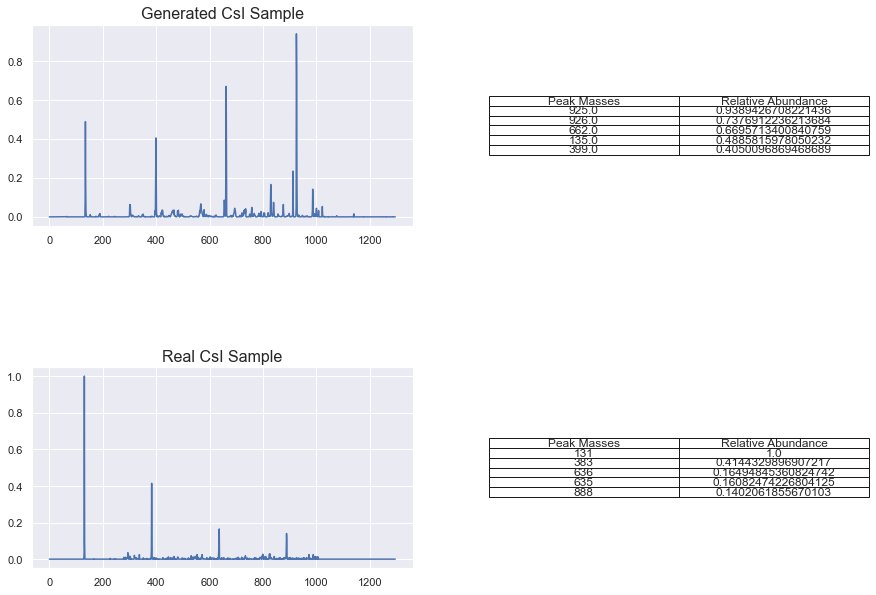

In [542]:
# Plot generated mass spectrum
f, axs = plt.subplots(2,2,figsize=(15,10))

plt.subplot(2,2,1)
gen_spec_df.iloc[0].plot(legend=None)
plt.title("Generated "+target_name+" Sample",fontsize=16)

plt.subplot(2,2,2)
cell_text1 = []
for row in range(len(gen_peaks)):
    cell_text1.append(gen_peaks.iloc[row])
plt.table(cellText=cell_text1, colLabels=gen_peaks.columns, loc='center', cellLoc='center')
plt.axis('off')

plt.subplot(2,2,3)
target_df.iloc[5].plot(legend=None)
plt.title("Real "+target_name+" Sample", fontsize=16)

plt.subplot(2,2,4)
cell_text2 = []
for row in range(len(real_peaks)):
    cell_text2.append(real_peaks.iloc[row])
plt.table(cellText=cell_text2, colLabels=real_peaks.columns, loc='center', cellLoc='center')
plt.axis('off')

f.subplots_adjust(hspace=.7)
plt.show()

The generative model emulates the four larger peaks in this particular sample. From a classification algorithm standpoint this is generally acceptable but it would not stand up to a manual inspection. Given that this sample was generated with a model used for image creation, this makes sense because recreating features as they relate to one another takes precedence over the particular location of any one feature. For example, in an image of a person wearing sunglasses the relationship of the sunglasses to the face of the person matters more than where the face exists in the image.

## Classifier Test

In [544]:
# Encode target classes
label_encoder = LabelEncoder()
y_train_cat = label_encoder.fit_transform(full_df['sample_label'])

# Map labels to encoding
target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [545]:
# Somewhat subjective, chosen here by max predicted probabilty
best_epoch = [500, 1750, 850, 250, 1150, 650, 2850]

In [546]:
# Generate and evaluate 100 samples from the list of samples
generated_results_df = pd.DataFrame(columns=['Sample Name','Predicted Name','Average Probability'])
sample_list = ['Atacama','Au-Coated CsI','CsI','Hematite','Thin section (R-Gypsum)','TiO2','Yellowstone Green stream powder']
for sample in sample_list:
    # load json and create model
    json_file = open('DCGAN/models/' + sample + '/generator_model_' + str(best_epoch[sample_list.index(sample)]) + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights("DCGAN\models\/" + sample + '\generator_model_' + str(best_epoch[sample_list.index(sample)]) + '.h5')
    
    # generate 100 samples
    noise = np.random.normal(0, 1, (100, LATENT_DIM))
    gen_imgs = loaded_model.predict(noise)

    # rescale from [0,1]
    gen_imgs = .5 * gen_imgs + .5

    # Reshape back to spectrum
    gen_spec = gen_imgs.reshape(100,1296)
    gen_spec_df = pd.DataFrame(gen_spec)

    # Create simple model
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    classifier.fit(norm_spec_df, y_train_cat)
    
    # Find most often predicted label
    y_pred = classifier.predict(gen_spec_df)
    most_pred = np.argmax(np.bincount(y_pred))
    pred_class = [k for k,v in target_mapping.items() if v == most_pred][0]
    
    # Find average prediction probability
    y_probs = classifier.predict_proba(gen_spec_df)[:,target_mapping[sample]]
    y_avg = np.average(y_probs)
    
    generated_results_df = generated_results_df.append({"Sample Name":sample,"Predicted Name":pred_class,'Average Probability':"{0:.2%}".format(y_avg)},ignore_index=True)

In [547]:
# Add total number of samples to the results dataframe
s_counts = []
for s_name in generated_results_df['Sample Name']:
    s_counts.append(sample_counts[s_name])
generated_results_df['Sample Count'] = s_counts

# Format the results dataframe
generated_results_df.sort_values(by=['Average Probability'],ascending=False).style.hide_index().set_properties(**{'text-align': 'left'}).set_properties(subset=["Average Probability","Sample Count"], **{'text-align': 'center'}).set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

Using the 'best' generator versions for each sample label, 100 new samples were generated and then passed to a simple linear classfication algorithm that had been trained on the full MOMA ML dataset. The hypothesis that samples with the largest number of observations would be most easily replicated has been demonstrated as incorrect. Atacama and Yellowstone Green stream powder contain roughly half the observations of the other samples included here yet outperformed. Presumably these samples produce a distinct pattern that is easily distinguishable when presented in this fashion, perhaps due to having fewer modes.

Further investigation is needed to determine whether the observations produced with this method would be beneficial if added to the current MOMA ML training dataset. 

### [BACK TO TOP](#top)